In [1]:
import os
import pandas as pd
import numpy as np
import nltk
import re
import sklearn
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

In [2]:
from transformers import TFAutoModel, PhobertTokenizer, AutoTokenizer, AutoModel, TFAutoModelForSequenceClassification
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Lambda, Flatten, Bidirectional, MaxPooling1D, UpSampling2D, AveragePooling2D, Flatten, Dropout, Input, Dense, Conv1D, Conv2D, BatchNormalization, Activation, GlobalMaxPooling1D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model, load_model, model_from_config
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import imagenet_utils, inception_resnet_v2, EfficientNetB4, InceptionResNetV2
from tensorflow.keras.utils import to_categorical

In [3]:
!pwd

/home/khoatm4/Elastic_search


In [4]:
data = pd.read_csv('/home/khoatm4/Elastic_search/data/train_sample.csv')
data.label -= 1

In [5]:
data = sklearn.utils.shuffle(data, random_state=21)

In [6]:
data.reset_index(drop=True, inplace=True)

In [7]:
data.title = data.title.str.replace('name','')
data.title = data.title.str.replace('number','')
data.title = data.title.str.replace('percent','')
data.title = data.title.str.replace('date','')
data.title = data.title.str.replace('loc','')
data.title = data.title.str.replace('  ',' ')

In [8]:
data

,title,label
0,thị_trường_chứng_khoán có sức phục_hồi mạnh nh...,2
1,lỗ luỹ kế vượt vốn_điều_lệ cổ_phiếu của sắp bị...,0
2,tin giao_dịch lượng lớn cổ_phiếu,1
3,thông_tin chính_thức về khả_năng niêm_yết vin...,2
4,áp_dụng cải_tiến về kỹ_thuật vận_hành tình_tr...,2
...,...,...
1054,vẫn tăng kịch trần dù lỗ luỹ kế sau kiểm_toán...,0
1055,được định_giá tỷ khi bán cho,2
1056,chứng_khoán lên phương_án phát_hành tăng vốn ...,2
1057,khối ngoại bán ròng trên mất hơn điểm trong p...,0


In [ ]:
# Labels
# Negative: 0
# Neutral: 1
# Positive: 2

In [9]:
title = data.title
y = data.label

In [10]:
texts = list(title)
indices = list(y)

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 256

In [12]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base") #Tokenizer

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
#x_train, x_test, y_train, y_test = train_test_split(texts, indices, test_size=0.2, random_state=21, stratify=indices)

In [14]:
inputs = tokenizer(texts, padding=True, truncation=False, return_tensors='tf') #Tokenized text
dataset = tf.data.Dataset.from_tensor_slices((dict(inputs), indices)) #Create a tensorflow dataset

val_data_size = int(0.15 * len(texts))
val_ds = dataset.take(val_data_size).batch(batch_size, drop_remainder=False)
train_ds = dataset.skip(val_data_size).batch(batch_size, drop_remainder=False)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
train_ds

<PrefetchDataset shapes: ({input_ids: (None, 28), token_type_ids: (None, 28), attention_mask: (None, 28)}, (None,)), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [17]:
val_ds

<BatchDataset shapes: ({input_ids: (None, 28), token_type_ids: (None, 28), attention_mask: (None, 28)}, (None,)), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [18]:
tokens = tokenizer(texts[0:3], padding=True, truncation=True)['input_ids']
for i in range(3):
    print('Input:',texts[i])
    print('Subword tokenization:',tokenizer.tokenize(texts[i]))
    print('Indices:', tokens[i], end='\n\n')

Input: thị_trường_chứng_khoán có sức phục_hồi mạnh nhất và lọt top thế_giới
Subword tokenization: ['thị_trường_chứng_khoán', 'có', 'sức', 'phục_hồi', 'mạnh', 'nhất', 'và', 'lọt', 'top', 'thế_giới']
Indices: [0, 5124, 10, 760, 2646, 384, 67, 6, 2294, 2486, 198, 2, 1]

Input: lỗ luỹ kế vượt vốn_điều_lệ cổ_phiếu của sắp bị huỷ niêm_yết
Subword tokenization: ['lỗ', 'luỹ', 'kế', 'vượt', 'vốn_điều_lệ', 'cổ_phiếu', 'của', 'sắp', 'bị', 'huỷ', 'niêm_yết']
Indices: [0, 2536, 9373, 3900, 510, 4511, 1025, 7, 984, 45, 3374, 2784, 2]

Input:       tin giao_dịch lượng lớn cổ_phiếu
Subword tokenization: ['tin', 'giao_dịch', 'lượng', 'lớn', 'cổ_phiếu']
Indices: [0, 200, 786, 525, 103, 1025, 2, 1, 1, 1, 1, 1, 1]



In [19]:
sgd = SGD(learning_rate=1e-5, momentum=0.9, decay=0.000001)
adam = Adam(learning_rate=1e-5)

In [20]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              patience= 2,
                              factor= 0.3,
                              min_lr= 1e-9,
                              verbose=1)

In [21]:
model = TFAutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)

Downloading:   0%|          | 0.00/706M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# model.compile(optimizer=sgd , loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#
# history=model.fit(train_ds, validation_data=val_ds, epochs=6, verbose=1)

In [23]:
model.compile(
    optimizer = adam,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [tf.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

H = model.fit(train_ds,
              validation_data=val_ds,
              callbacks = [reduce_lr],
              epochs=30,
              verbose=1)

Epoch 1/30
4/4 [==============================] - 54s 9s/step - loss: 1.0677 - accuracy: 0.4950 - val_loss: 1.0102 - val_accuracy: 0.5633
Epoch 2/30
4/4 [==============================] - 32s 8s/step - loss: 1.0100 - accuracy: 0.5527 - val_loss: 0.9608 - val_accuracy: 0.5633
Epoch 3/30
4/4 [==============================] - 31s 8s/step - loss: 0.9755 - accuracy: 0.5516 - val_loss: 0.9350 - val_accuracy: 0.5633
Epoch 4/30
4/4 [==============================] - 31s 8s/step - loss: 0.9632 - accuracy: 0.5516 - val_loss: 0.9164 - val_accuracy: 0.5633
Epoch 5/30
4/4 [==============================] - 31s 8s/step - loss: 0.9527 - accuracy: 0.5516 - val_loss: 0.8940 - val_accuracy: 0.5633
Epoch 6/30
4/4 [==============================] - 31s 7s/step - loss: 0.9335 - accuracy: 0.5516 - val_loss: 0.8714 - val_accuracy: 0.5633
Epoch 7/30
4/4 [==============================] - 31s 8s/step - loss: 0.9186 - accuracy: 0.5538 - val_loss: 0.8506 - val_accuracy: 0.6266
Epoch 8/30
4/4 [==================

In [29]:
H = model.fit(train_ds,
              validation_data=val_ds,
              callbacks = [reduce_lr],
              epochs=10,
              verbose=1)

Epoch 1/10
4/4 [==============================] - 30s 7s/step - loss: 0.2169 - accuracy: 0.9423 - val_loss: 0.4433 - val_accuracy: 0.8608
Epoch 2/10
4/4 [==============================] - 30s 7s/step - loss: 0.2055 - accuracy: 0.9467 - val_loss: 0.4224 - val_accuracy: 0.8354
Epoch 3/10
4/4 [==============================] - 30s 7s/step - loss: 0.1897 - accuracy: 0.9556 - val_loss: 0.4168 - val_accuracy: 0.8291
Epoch 4/10
4/4 [==============================] - 30s 7s/step - loss: 0.1757 - accuracy: 0.9612 - val_loss: 0.4505 - val_accuracy: 0.8481
Epoch 5/10
4/4 [==============================] - 30s 7s/step - loss: 0.1498 - accuracy: 0.9689 - val_loss: 0.4295 - val_accuracy: 0.8354

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
Epoch 6/10
4/4 [==============================] - 30s 7s/step - loss: 0.1505 - accuracy: 0.9656 - val_loss: 0.4144 - val_accuracy: 0.8418
Epoch 7/10
4/4 [==============================] - 31s 7s/step - loss: 0.1503 - accuracy: 0

In [30]:
H = model.fit(train_ds,
              validation_data=val_ds,
              callbacks = [reduce_lr],
              epochs=10,
              verbose=1)

Epoch 1/10
4/4 [==============================] - 30s 7s/step - loss: 0.1262 - accuracy: 0.9756 - val_loss: 0.4303 - val_accuracy: 0.8544
Epoch 2/10
4/4 [==============================] - 31s 7s/step - loss: 0.1284 - accuracy: 0.9734 - val_loss: 0.4167 - val_accuracy: 0.8481
Epoch 3/10
4/4 [==============================] - 30s 7s/step - loss: 0.1209 - accuracy: 0.9778 - val_loss: 0.4074 - val_accuracy: 0.8481
Epoch 4/10
4/4 [==============================] - 30s 7s/step - loss: 0.1206 - accuracy: 0.9800 - val_loss: 0.4095 - val_accuracy: 0.8481
Epoch 5/10
4/4 [==============================] - 31s 8s/step - loss: 0.1162 - accuracy: 0.9711 - val_loss: 0.4198 - val_accuracy: 0.8671

Epoch 00005: ReduceLROnPlateau reducing learning rate to 8.999999636216671e-07.
Epoch 6/10
4/4 [==============================] - 30s 7s/step - loss: 0.1176 - accuracy: 0.9778 - val_loss: 0.4233 - val_accuracy: 0.8671
Epoch 7/10
4/4 [==============================] - 31s 8s/step - loss: 0.1094 - accuracy: 0.

In [31]:
def plot_acc_loss(H):
    fig, ax = plt.subplots(1,2, figsize=(14,7))
    ax[0].plot(H.history['accuracy'])
    ax[0].plot(H.history['val_accuracy'])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(H.history['loss'])
    ax[1].plot(H.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper right')
    plt.show()

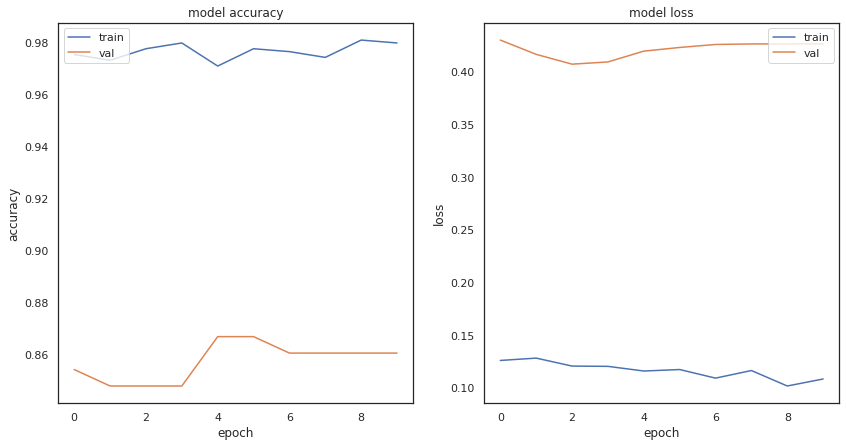

In [32]:
plot_acc_loss(H)

In [33]:
logits = model.predict(val_ds, verbose=1).logits
prob = tf.nn.softmax(logits, axis=1).numpy()
predictions = np.argmax(prob, axis=1)

label_test = np.concatenate([y for x, y in val_ds], axis=0)

1/1 [==============================] - 1s 1s/step


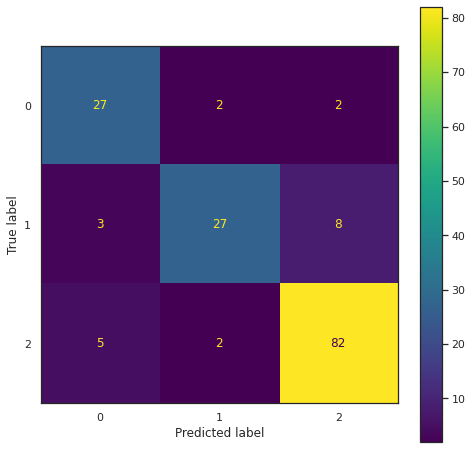

In [35]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))
cm = confusion_matrix(label_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)

In [36]:
print(classification_report(label_test,predictions))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82        31
           1       0.87      0.71      0.78        38
           2       0.89      0.92      0.91        89

    accuracy                           0.86       158
   macro avg       0.84      0.83      0.84       158
weighted avg       0.86      0.86      0.86       158

